# Think Bayes: Chapter 10

This notebook presents code and exercises from Think Bayes, second edition.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from itertools import product
from IPython.display import display
from scipy import stats
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import mythinkbayes as mtb
import numpy as np
import pandas as pd
import pdb

'Done'

'Done'

In [2]:
# Imports from Downey's code.
import sys; sys.path.append('ThinkBayes2/code')
import brfss
import thinkplot
'Done'

'Done'

In [3]:
# Read data using Downey's code.
df = brfss.ReadBrfss(filename='ThinkBayes2/code/CDBRFS08.ASC.gz')
df = df[['sex', 'htm3']]
df.dropna(inplace=True)
df.sex.replace({2: 'F', 1: 'M'}, inplace=True)
display(df.head(), df.shape)

,sex,htm3
0,F,157.0
1,F,163.0
2,F,165.0
3,M,170.0
4,M,185.0


(409129, 2)

In [4]:
grouped = df.groupby('sex')
df_m = grouped.get_group('M')
df_f = grouped.get_group('F')

assert df_m.htm3.isna().any() == False
assert df_f.htm3.isna().any() == False

df_m.shape, df_f.shape

((154407, 2), (254722, 2))

In [5]:
np.median(df_m.htm3)

178.0

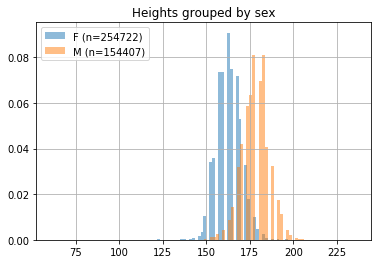

In [6]:
for sex, group in df.groupby('sex'):
    group.htm3.hist(label='%s (n=%d)' % (sex, len(group)), alpha=0.5, bins=100, density=True)
plt.title('Heights grouped by sex')
plt.legend()
plt.show()

## Estimating Mean and Standard Deviation

Estimate the parameters of a Gaussian distribution: mean $\mu$, standard deviation $\sigma$.

Use classical estimators to find a likely location and spread for $\mu$ and $\sigma$. Then use Bayesian updates to compute a posterior.

If we take a sample of $n$ values, an estimator of $\mu$ is the sample mean $m$ and an estimator of $\sigma$ is the sample standard variance $s$. The standard error of the estimated $\mu$ is $\frac{s}{\sqrt n}$ and standard error of estimated $\sigma$ is $\frac{s}{\sqrt{2(n - 1)}}$.

Various update methods are implemented:

1. `update()` is a naive scheme that computes and multiplies likelihoods. This suffers from underflow after ~200 updates.
2. `log_update()` computes and adds log-likelihoods. This avoids underflow but is still pretty slow.
3. `log_update_fast()` computes and adds log-likelihoods, taking advantage of the fact that the PDF can be split into terms that depend on $\mu$ and $\sigma$ separately. It caches these terms and re-uses them for a ~100x speedup over `log_update()`.
4. `log_update_approx()` computes approximate log-likelihoods using the sample mean and standard deviation. With a hypothesis space of (100 x 100) and above, this is a significant speedup over `log_update_fast()`.
5. `log_update_approx_robust()` implements the same update as `log_update_approx()`, but uses median and percentile range instead of sample mean and standard deviation to minimize the effect of outliers.

Male, n=154407
Smallest [61.0, 74.0, 76.0, 81.0, 86.0, 89.0, 89.0, 91.0, 97.0, 101.0]
Largest [218.0, 221.0, 221.0, 221.0, 221.0, 225.0, 226.0, 229.0, 229.0, 236.0]
Percentiles [25, 50, 75] = [173, 178, 183]
---
Female, n=254722
Smallest [61.0, 61.0, 64.0, 66.0, 74.0, 81.0, 89.0, 89.0, 89.0, 91.0]
Largest [213.0, 213.0, 213.0, 213.0, 221.0, 226.0, 229.0, 229.0, 229.0, 229.0]
Percentiles [25, 50, 75] = [157, 163, 168]
---
Prior estimators m=178.066, s=7.724
Prior estimators m=163.223, s=7.269
log_update_fast
CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 59.4 ms
CPU times: user 64 ms, sys: 0 ns, total: 64 ms
Wall time: 66.3 ms
Male mu ~ (178.066221, 0.000379), sigma ~ (7.723620, 0.000189)
Male MAP ((178.06622109101272, 7.723563454784915), 0.006390461518374871)
Female mu ~ (163.223475, 0.000203), sigma ~ (7.269189, 0.000102)
Female MAP ((163.22347500412215, 7.269156286642232), 0.0063904689082552755)


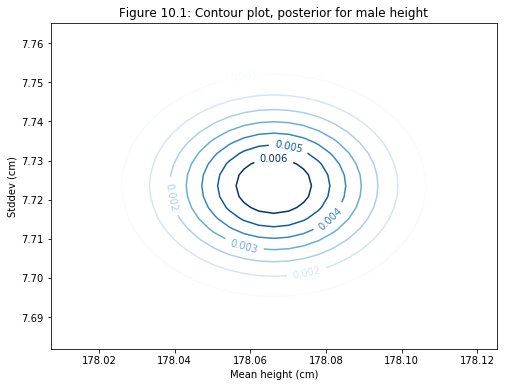

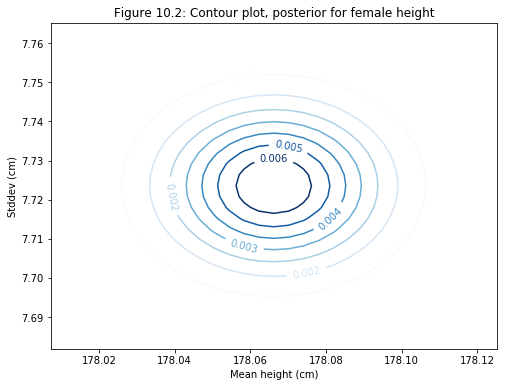

----------------------------------------------------------------------------------------------------
log_update_approx
178.06622109101272 7.723538444338627
CPU times: user 152 ms, sys: 0 ns, total: 152 ms
Wall time: 437 ms
163.22347500412215 7.269142017824814
CPU times: user 376 ms, sys: 8 ms, total: 384 ms
Wall time: 456 ms
Male mu ~ (178.066221, 0.000379), sigma ~ (7.723583, 0.000189)
Male MAP ((178.06622109101272, 7.723563454784915), 0.00639046710523236)
Female mu ~ (163.223475, 0.000203), sigma ~ (7.269167, 0.000102)
Female MAP ((163.22347500412215, 7.269156286642232), 0.0063904722945376646)


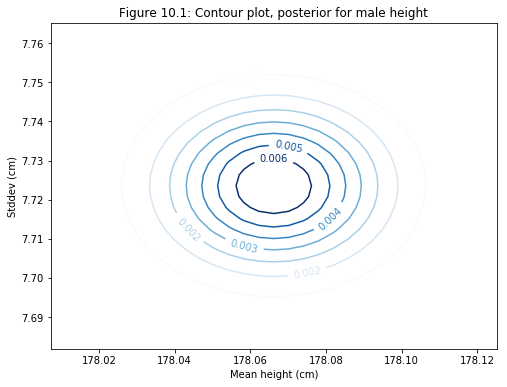

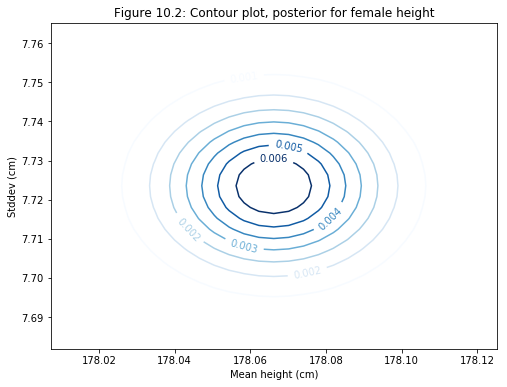

----------------------------------------------------------------------------------------------------
log_update_approx_robust
Prior estimators m=178.000, s=7.500
Prior estimators m=163.000, s=6.500
CPU times: user 480 ms, sys: 48 ms, total: 528 ms
Wall time: 499 ms
CPU times: user 508 ms, sys: 36 ms, total: 544 ms
Wall time: 522 ms
Male mu ~ (178.000000, 0.000357), sigma ~ (7.500042, 0.000178)
Male MAP ((178.0, 7.5), 0.006390481665354101)
Female mu ~ (163.000000, 0.000163), sigma ~ (6.500022, 0.000081)
Female MAP ((163.0, 6.5), 0.006390481120502918)


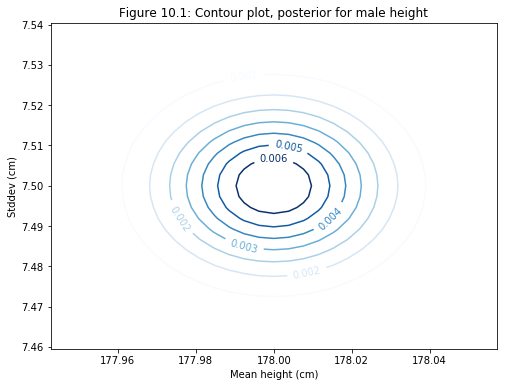

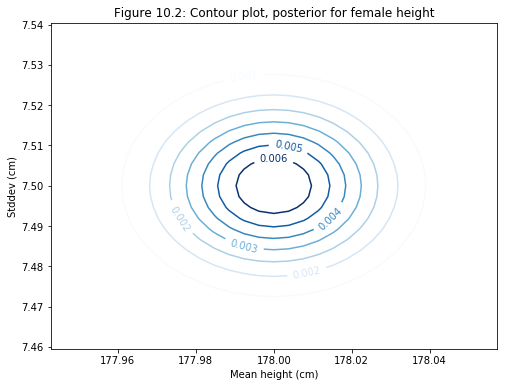

In [7]:
class NormalParameters(mtb.PMF, mtb.Joint):
    
    def __init__(self, mus, sigmas):
        hypos = list(product(mus, sigmas))
        super().__init__(hypos)
        self.mus = mus
        self.sigmas = sigmas

    def update(self, data):
        """Vectorized regular update.
        
        The multiplication of tiny probabilities will cause underflow for len(data) > ~200.
        
        # Arguments:
            data: list-like of scalars.
        
        # Returns:
            self: updated, normalized instance of self.
        """
        
        for mu, sigma in tqdm(self.hypos, desc='Updating hypotheses'):
            rv = stats.norm(mu, sigma)
            likes = rv.pdf(data)  
            self[(mu, sigma)] *= likes.prod()
        
        return self.normalize()
    
    def log_update(self, data):
        """Vectorized log-transformed update.
        
        # Arguments:
            data: list-like of scalars.
        
        # Returns:
            self: updated, normalized instance of self.
        """
        
        # Normalize by the highest probability and log transform.
        self[:] = np.log(self.values / self.values.max())
        
        # Increment each hypothesis by the sum of the log-likelihoods
        # of the given data values under that hypothesis.
        for mu, sigma in self.hypos:
            loglikes = stats.norm.logpdf(data, mu, sigma)
            self[(mu, sigma)] += loglikes.sum()
            
        # Invert the transformation.
        self[:] = np.exp(self.values - self.values.max())
        
        return self.normalize()
    
    def log_update_fast(self, data):
        """Vectorized log-transformed update using dynamic programming (caching).
        
        # Arguments:
            data: list-like of scalars.
        
        # Returns:
            self: updated, normalized instance of self.
        """
        
        # Normalize by the highest probability and log transform.
        self[:] = np.log(self.values / self.values.max())
        
        # Increment each hypothesis by the sum of the log-likelihoods
        # of the given data values under that hypothesis.
        
        # Keep a cache of previously computed values corresponding to each
        # value of sigma and mu.
        cache = dict()
        
        for mu, sigma in self.hypos:
              
            # Compute log-likelihood with caching.
            # Refer to book for the exact equation.
            # Note that the term a leaves out the constant 1 / (sqrt(2 * \pi) * sigma).
            key = ('s', sigma)
            ab = cache.get(key)
            if not ab:
                a = -len(data) * np.log(sigma)
                b = -1 / (2 * sigma**2)
                cache[key] = (a, b)
            else:
                a, b = ab
                
            key = ('m', mu)
            c = cache.get(key)
            if not c:
                c = np.sum((data - mu) ** 2)
                cache[key] = c
            
            loglike = a + (b * c)
            self[(mu, sigma)] += loglike
        
        # Invert the transformation.
        self[:] = np.exp(self.values - self.values.max())
        
        return self.normalize()
    
    def log_update_approx(self, data):
        """Approximated update using sample mean and variance.
        
        # Arguments:
            data: list-like of scalars.
        
        # Returns:
            self: updated, normalized instance of self.
        """
        
        # Normalize by the highest probability and log transform.
        self[:] = np.log(self.values / self.values.max())
        
        m, s, n = data.mean(), data.std(), len(data)
        
        print(m, s)
        
        # Increment each hypothesis by the sum of the log-likelihoods
        # of the given data values under that hypothesis.
        for mu, sigma in self.hypos:
            
            # Log-likelihood of the observed sample mean.
            center = mu
            spread = sigma / np.sqrt(n)
            loglike = stats.norm.logpdf(m, center, spread)
            
            # Log-likelihood of the observed sample standard error.
            center = sigma
            spread = sigma / np.sqrt(2 * (n - 1))
            loglike += stats.norm.logpdf(s, center, spread)
            
            self[(mu, sigma)] += loglike
            
        # Invert the transformation.
        self[:] = np.exp(self.values - self.values.max())
        
        return self.normalize()
    
    def log_update_approx_robust(self, data, z=1):
        """Approximated update using sample mean and variance.
        
        # Arguments:
            data: list-like of scalars.
            z: number of standard deviations used to get the percentiles which are
            then used to compute a robust standard deviation estimate.
        
        # Returns:
            self: updated, normalized instance of self.
        """
        
        # Normalize by the highest probability and log transform.
        self[:] = np.log(self.values / self.values.max())
        
        cdf = mtb.PMF.from_observations(data).to_cdf()
        
        # Use median to estimate center.
        m = cdf.percentile(50)
        
        # Use z to compute the percentile at (mean + z * sigma) and (mean - z * sigma).
        # Compute the value at each of those percentiles, and divide by 2 * z to
        # to estimate the standard deviation. This will minimize the effect
        # of outliers on the standard deviation estimate.
        p = stats.norm(0, 1).cdf(z)
        s = (cdf.percentile(p) - cdf.percentile(1 - p)) / (2 * z)
        
        n = len(data)
        
        # Increment each hypothesis by the sum of the log-likelihoods
        # of the given data values under that hypothesis.
        for mu, sigma in self.hypos:
            
            # Log-likelihood of the observed sample mean.
            center = mu
            spread = sigma / np.sqrt(n)
            loglike = stats.norm.logpdf(m, center, spread)
            
            # Log-likelihood of the observed sample standard error.
            center = sigma
            spread = sigma / np.sqrt(2 * (n - 1))
            loglike += stats.norm.logpdf(s, center, spread)
            
            self[(mu, sigma)] += loglike
            
        # Invert the transformation.
        self[:] = np.exp(self.values - self.values.max())
        
        return self.normalize()
    
def normal_prior_from_data(heights, prior_n=31, prior_z=3, s_z=1, use_median=False):
    
    if use_median:
        cdf = mtb.PMF.from_observations(heights).to_cdf()
        m = np.median(heights)
        p = stats.norm(0, 1).cdf(s_z)
        s = (cdf.percentile(p) - cdf.percentile(1 - p)) / 2 / s_z
    else:
        m, s = heights.mean(), heights.std()
        
    print('Prior estimators m=%.3lf, s=%.3lf' % (m, s))
    
    # Range for $\mu$.
    center = m
    spread = s / np.sqrt(len(heights))
    mus = np.linspace(center - prior_z * spread, center + prior_z * spread, prior_n)
    
    # Range for $\sigma$.
    center = s
    spread = s / np.sqrt(2 * (len(heights) - 1))
    sigmas = np.linspace(center - prior_z * spread, center + prior_z * spread, prior_n)
    
    return mus, sigmas

def summarize_data(which, heights):
    X = sorted(heights)
    cdf = mtb.PMF.from_observations(X).to_cdf()
    
    print('%s, n=%d' % (which, len(X)))
    print('Smallest', X[:10])
    print('Largest', X[-10:])
    print('Percentiles [25, 50, 75] = [%d, %d, %d]' % (
        cdf.percentile(25), cdf.percentile(50), cdf.percentile(75)))
    print('---')

def summarize_parameters(prm_m, prm_f):
    mm, ms = prm_m.marginal(0), prm_m.marginal(1)
    print('Male mu ~ (%.6lf, %.6lf), sigma ~ (%.6lf, %.6lf)' % (
        mm.expectation(), mm.var(), ms.expectation(), ms.var()))
    print('Male MAP', prm_m.MAP())

    mm, ms = prm_f.marginal(0), prm_f.marginal(1)
    print('Female mu ~ (%.6lf, %.6lf), sigma ~ (%.6lf, %.6lf)' % (
        mm.expectation(), mm.var(), ms.expectation(), ms.var()))
    print('Female MAP', prm_f.MAP())
    
    thinkplot.Clf()
    thinkplot.Contour(prm_m.to_dict(), pcolor=False, contour=True)
    plt.xlabel('Mean height (cm)')
    plt.ylabel('Stddev (cm)')
    plt.title('Figure 10.1: Contour plot, posterior for male height')
    plt.show()
    
    thinkplot.Clf()
    thinkplot.Contour(prm_m.to_dict(), pcolor=False, contour=True)
    plt.xlabel('Mean height (cm)')
    plt.ylabel('Stddev (cm)')
    plt.title('Figure 10.2: Contour plot, posterior for female height')
    plt.show()
    
    
summarize_data('Male', df_m.htm3)
summarize_data('Female', df_f.htm3)
    
priors_m = normal_prior_from_data(df_m.htm3)
priors_f = normal_prior_from_data(df_f.htm3)
    
# Too slow.
# print('log_update')
# prm_m = NormalParameters(*priors_m)
# prm_f = NormalParameters(*priors_f)
# prm_m.log_update(df_m.htm3.values)
# prm_f.log_update(df_f.htm3.values)
# summarize_parameters(prm_m, prm_f)
# print('-' * 100)

print('log_update_fast')
prm_m = NormalParameters(*priors_m)
prm_f = NormalParameters(*priors_f)
%time prm_m.log_update_fast(df_m.htm3.values)
%time prm_f.log_update_fast(df_f.htm3.values)
summarize_parameters(prm_m, prm_f)
print('-' * 100)

print('log_update_approx')
prm_m = NormalParameters(*priors_m)
prm_f = NormalParameters(*priors_f)
%time prm_m.log_update_approx(df_m.htm3.values)
%time prm_f.log_update_approx(df_f.htm3.values)
summarize_parameters(prm_m, prm_f)
print('-' * 100)

print('log_update_approx_robust')
priors_m = normal_prior_from_data(df_m.htm3, use_median=True)
priors_f = normal_prior_from_data(df_f.htm3, use_median=True)
prm_m = NormalParameters(*priors_m)
prm_f = NormalParameters(*priors_f)
%time prm_m.log_update_approx_robust(df_m.htm3.values)
%time prm_f.log_update_approx_robust(df_f.htm3.values)
summarize_parameters(prm_m, prm_f)

## Who is more variable?

Coefficient of variation is the standard deviation divided by the mean.

$C_v = \frac{\sigma}{\mu}$

To express this as a distribution, we apply the division operation to the marginals of the PMFs computed above.

However, the result does not match the book. I attribute this to the lack of jittering on the heights, [described in this issue I posted to Downey's repository.](https://github.com/AllenDowney/ThinkBayes2/issues/9)

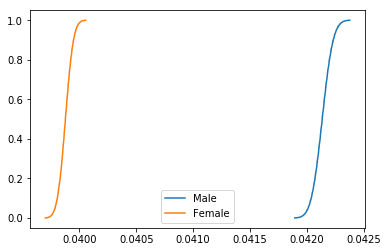

(0.04213507018943672, 0.03987743754466429)

In [8]:
def prm_to_cv(prm):
    c = Counter()
    for (mu, sigma), p in prm.items():
        c[sigma / mu] += p
    return mtb.PMF.from_dict(c)

cv_m = prm_to_cv(prm_m)
cv_f = prm_to_cv(prm_f)

cv_m.to_cdf().plot(label='Male')
cv_f.to_cdf().plot(label='Female')
plt.legend()
plt.show()

cv_m.expectation(), cv_f.expectation()

## Exercises

**Exercise 10.1:** An [effect size](https://en.wikipedia.org/wiki/Effect_size) is a statistic
intended to measure the difference between two groups.

For example, we could use he data from the BRFSS to estimate the difference in height between
men and women. By sampling values from the posterior distributions of $\mu$ and $\sigma$, we 
could generate the posterior distribution of this difference.

But it might be better to use a dimensionless measure of effect size, rather than a difference
measured in cm. One option is to divide through by the standard deviation.

If the parameters for Group 1 are $(\mu_1, \sigma_1)$ and the parameters for Group 2 are
$(\mu_2, \sigma_2)$, the dimesnionless effect size is:

$\frac{\mu_1 - \mu_2}{(\sigma_1 + \sigma_2) / 2}$

Write a function that takes joint distributions of $\mu$ and $\sigma$ for two groups and 
returns the posterior distribution of effect size.

CPU times: user 2.56 s, sys: 140 ms, total: 2.7 s
Wall time: 2.81 s


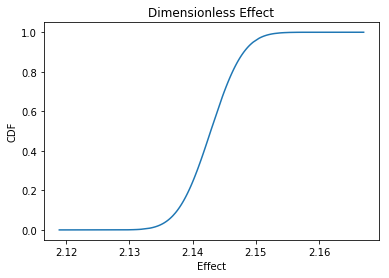

In [9]:
def prms_to_effect(prm_1, prm_2):
    """Compute an effect from two distributions of Normal parameters.
    
    This works as a sort-of mixture of effects."""
    c = dict()
    for (mu1, sigma1), p1 in prm_1.items():
        for (mu2, sigma2), p2 in prm_2.items():
            effect = (mu1 - mu2) / ((sigma1 + sigma2) / 2)
            if effect not in c:
                c[effect] = 1
            c[effect] *= p1 * p2
    return mtb.PMF.from_dict(c)

%time effect = prms_to_effect(prm_m, prm_f)
effect.to_cdf().plot()
plt.title('Dimensionless Effect')
plt.xlabel('Effect')
plt.ylabel('CDF')
plt.show()

In [10]:
'Done'

'Done'